In [1]:
import sys
sys.path.append('../')

import pandas as pd 
import seaborn as sns 
import numpy as np
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
from dft_descriptors.prepocessing import preprocess
from featurisation import process_dataframe
from analysis import analysis_stratification_influence, analysis_train_set_size

from sklearn.metrics import mean_absolute_error, accuracy_score, balanced_accuracy_score, explained_variance_score, r2_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA

In [2]:
df = pd.read_csv('data_csv/Data_test11042021.csv')
df = preprocess(df)
vc = df.DOI.value_counts()
doi_above_10 = np.array(vc[vc > 20].index)

indexes = []

for i, row in df.iterrows():
    if row["DOI"] not in doi_above_10:
        indexes.append(i)
        
df = df.drop(indexes)
df = df.reset_index(drop=True)

In [3]:
X, y, DOIs, mechanisms, origins = process_dataframe(df)

In [4]:
estimators = [('predictor', RandomForestRegressor())]
pipe = Pipeline(estimators)
metric = r2_score

# 1. Yields distribution by origin and mechanism

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 26.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 17.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


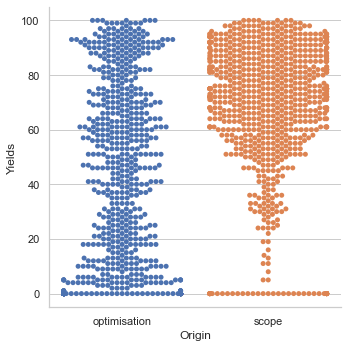

In [5]:
# Yield distribution according to scope/optimization
display_df =  pd.DataFrame(zip(y, mechanisms, origins), columns =['Yields', 'Mechanisms', 'Origin'])

sns.catplot(y="Yields", data=display_df, x='Origin',  kind="swarm")
plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 9.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 44.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 55.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/anacon

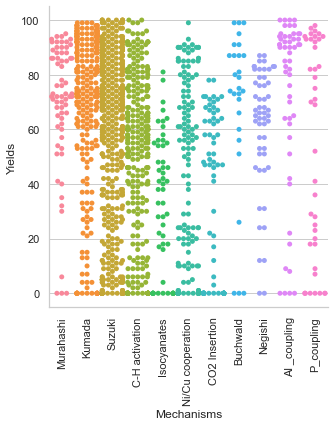

In [6]:
# Yield distribution according to mechanism
chart = sns.catplot(y="Yields", data=display_df, x='Mechanisms',  kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.show()

In [7]:
metric_values, baseline_values, sizes = analysis_train_set_size(X, y, DOIs, metric=metric, predictor=pipe, n_iterations_external=2, n_iterations_internal=1)

In [8]:
metric_mean = np.mean(metric_values, axis=1)
metric_lower = np.percentile(metric_values, 5, axis=1)
metric_upper = np.percentile(metric_values, 95, axis=1)

baseline_mean = np.mean(baseline_values, axis=1)
baseline_lower = np.percentile(baseline_values, 5, axis=1)
baseline_upper = np.percentile(baseline_values, 95, axis=1)

# 2. Evolution of performance with training data availibility

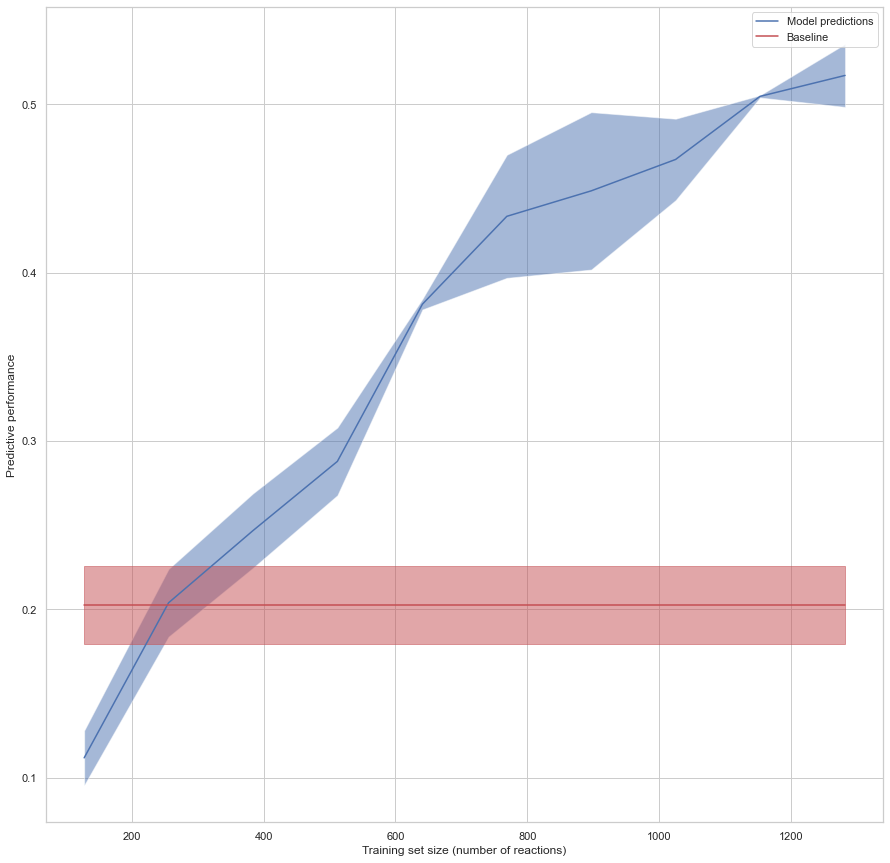

In [9]:
# How does (with fixed test set) performance improves as the training set size augments?
plt.figure(figsize=(15, 15))
plt.plot(sizes, metric_mean, label='Model predictions')
plt.fill_between(sizes, metric_lower, metric_upper, alpha=0.5)

plt.plot(sizes, baseline_mean, c='r', label='Baseline')
plt.fill_between(sizes, baseline_lower, baseline_upper, color='r', alpha=0.5)

plt.xlabel("Training set size (number of reactions)")
plt.ylabel("Predictive performance")

plt.legend()
plt.show()

In [10]:
metric_standalone, metric_augmented, metric_baseline_standalone, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence(X, y, DOIs, metric=metric, predictor = pipe, test_size=0.95, n_iterations=2)

In [11]:
metric_augmented = np.mean(metric_augmented, axis=1)
metric_standalone = np.mean(metric_standalone, axis=1)
metric_baseline_standalone = np.mean(metric_baseline_standalone, axis=1)


In [12]:
metric_mechanism, metric_augmented_mechanism, metric_baseline_mechanism, _, unique_stratification_mechanism, sizes_mechanism = analysis_stratification_influence(X, y, mechanisms, metric=metric, predictor = pipe, test_size=0.2, n_iterations=2)

In [13]:
metric_augmented_mechanism = np.mean(metric_augmented_mechanism, axis=1)
metric_mechanism = np.mean(metric_mechanism, axis=1)
metric_baseline_mechanism = np.mean(metric_baseline_mechanism, axis=1)

In [14]:
def doi_2_mechanism(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    mechanism = mechanisms[dois_indexes[0]]
    return mechanism

def doi_2_origin(DOIs, doi):
    dois_indexes = np.where(DOIs==doi)[0]
    origin = origins[dois_indexes[0]]
    return origin

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

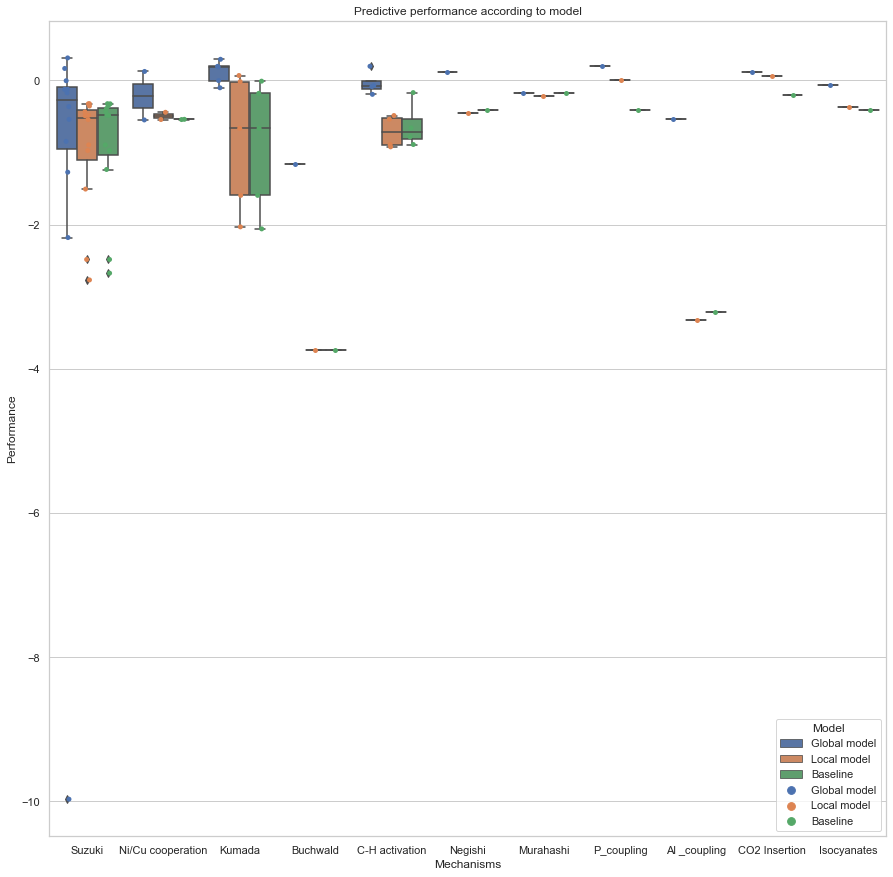

In [15]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_standalone, sizes, unique_stratification, mecha, orig, ["Local model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_standalone, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

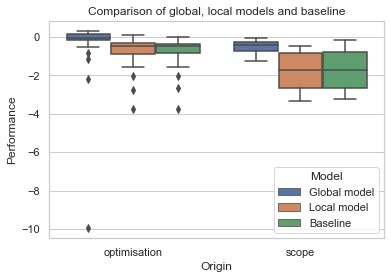

In [16]:
# Comparison of performance (distribution by DOI) of global, local and baseline models, stratified by scope/optimization

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

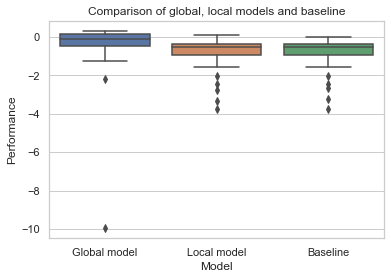

In [17]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models 

plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = 'Model', y="Performance",  data=display_df, dodge=True)
plt.show()

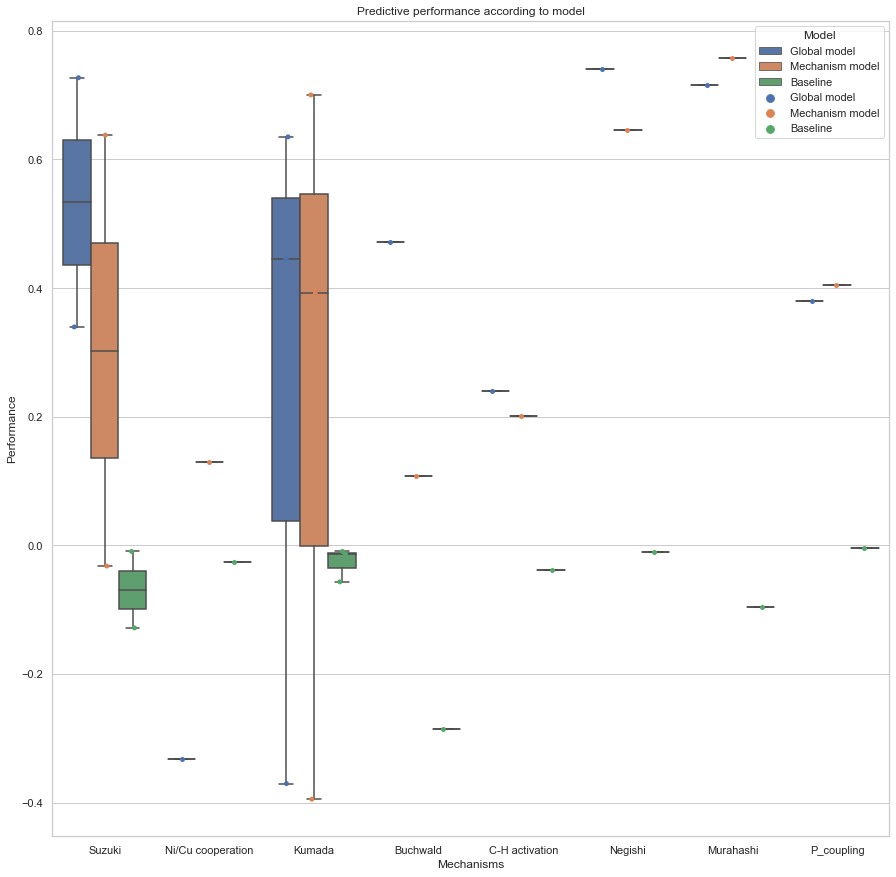

In [18]:
# Comparison of performance (distribution by mechanism) of global, local by mechanism and baseline models, stratified by mechanism

plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_augmented_mechanism, sizes, unique_stratification, mecha, orig, ["Global model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
local_df = pd.DataFrame(zip(metric_mechanism, sizes, unique_stratification, mecha, orig, ["Mechanism model" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline_mechanism, sizes, unique_stratification, mecha, orig, ["Baseline" for _ in range(len(sizes))]), columns =['Performance', "Size", "DOI", "Mechanisms", "Origin", "Model"])

display_df = pd.concat([global_df, local_df, baseline_df])

plt.title("Predictive performance according to model")
#plt.ylim(-5, 5)
sns.stripplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)
sns.boxplot(x = "Mechanisms", y="Performance",  data=display_df, hue="Model", dodge=True)

plt.show()

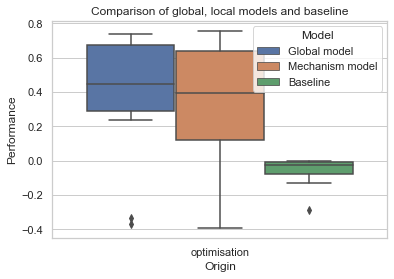

In [19]:
plt.title("Comparison of global, local models and baseline")
chart = sns.boxplot(x = "Origin", y="Performance",  data=display_df, hue="Model")

plt.show()

# 3. Increase of performance compared to baseline, by DOI

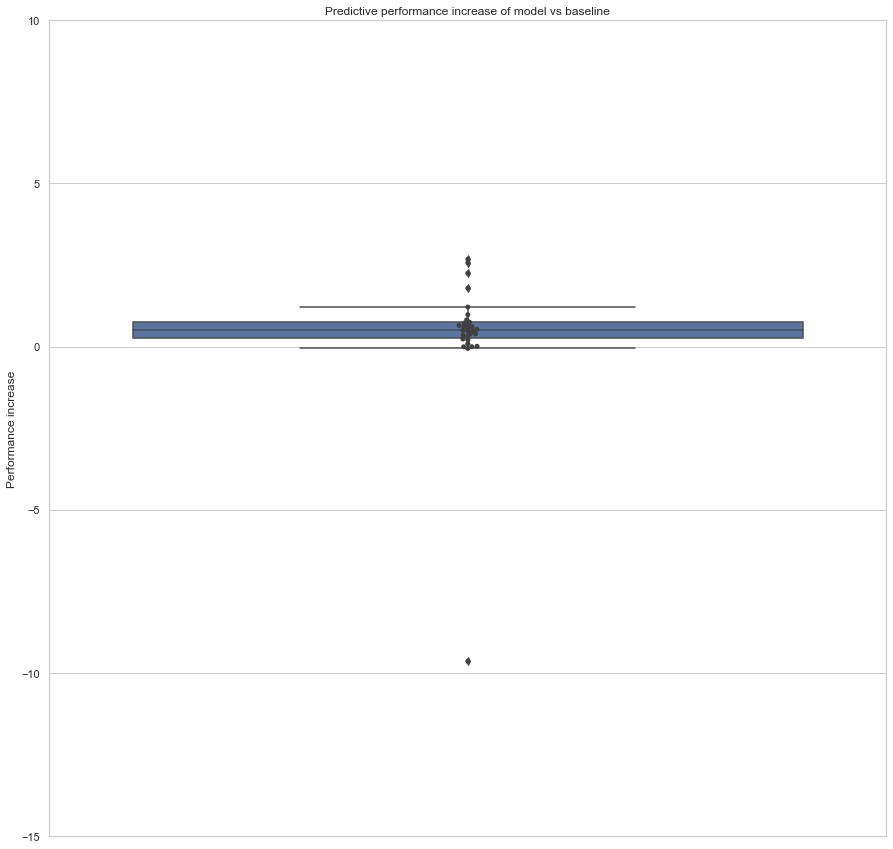

In [20]:
# Distribution of performance increase, global model vs baseline 
plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(metric_augmented-metric_baseline_standalone, columns =['Performance increase'])

plt.title("Predictive performance increase of model vs baseline")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")
plt.ylim(-15, 10)
plt.show()

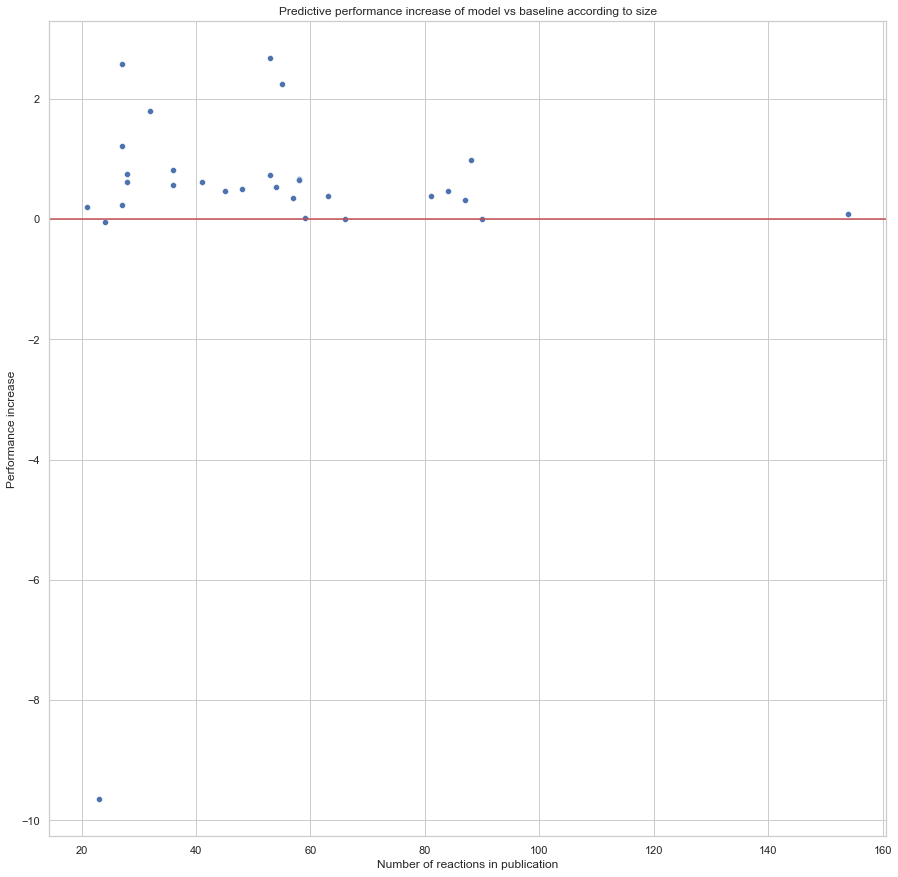

In [21]:
# Distribution of performance increase, global model vs baseline, by size of publication

plt.figure(figsize=(15, 15))

mecha = [doi_2_mechanism(DOIs, x) for x in unique_stratification]
orig = [doi_2_origin(DOIs, x) for x in unique_stratification]

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_baseline_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of model vs baseline according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

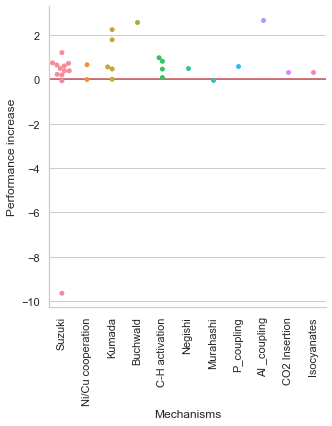

In [22]:
# Distribution of performance increase, global model vs baseline, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.show()

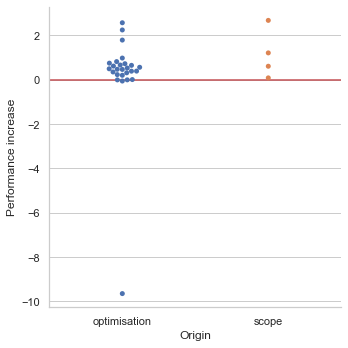

In [23]:
# Distribution of performance increase, global model vs baseline, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")

plt.axhline(0, c='r')
plt.show()

# 4. Increase of performance compared to local model, by DOI

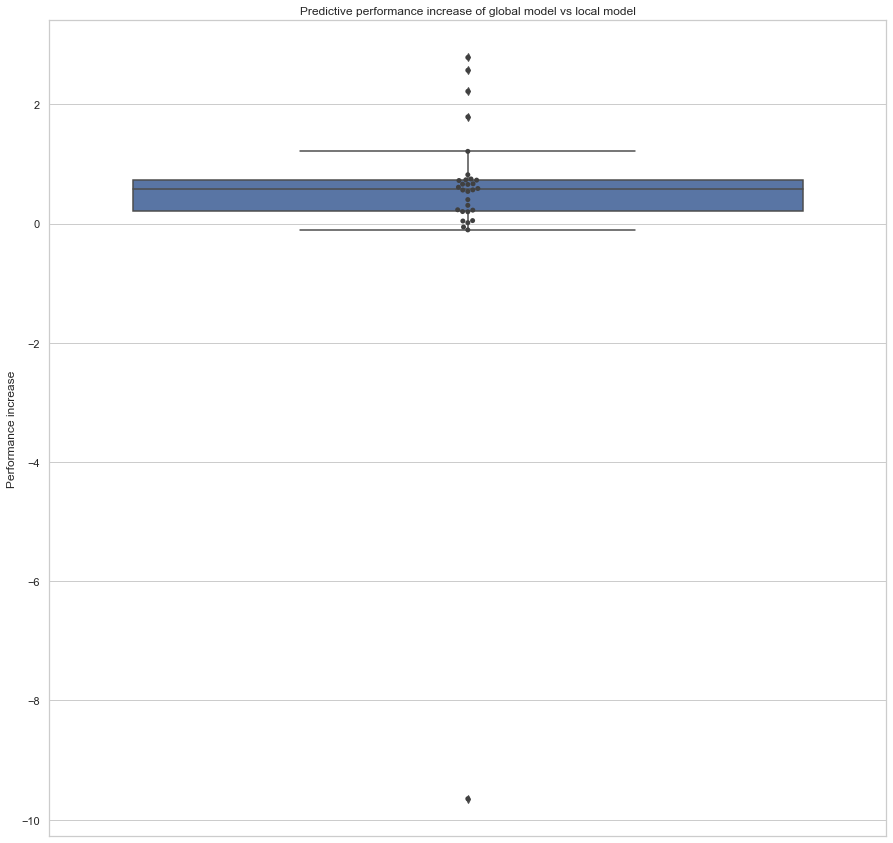

In [24]:
# Distribution of performance increase, global model vs local model

plt.figure(figsize=(15, 15))

display_df = pd.DataFrame(zip([x for x in metric_augmented-metric_standalone], sizes, unique_stratification, mecha, orig), columns =['Performance increase', "Size", "DOI", "Mechanisms", "Origin"])

plt.title("Predictive performance increase of global model vs local model")
sns.boxplot(y="Performance increase", data=display_df)
sns.swarmplot(y="Performance increase", data=display_df, color=".25")

plt.show()

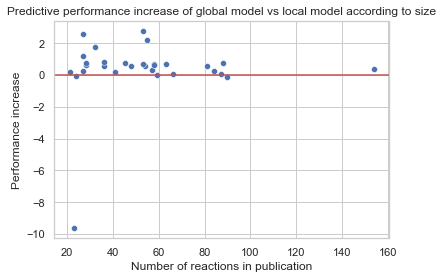

In [25]:
# Distribution of performance increase, global model vs local model, by size of publication

plt.title("Predictive performance increase of global model vs local model according to size")
sns.scatterplot(x="Size", y="Performance increase", data=display_df)
plt.xlabel("Number of reactions in publication")
#plt.ylim(-1, 1.5)
plt.axhline(0, c='r')

plt.show()

/usr/local/anaconda3/envs/dft_for_sm/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


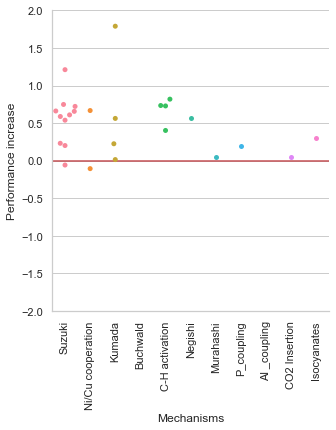

In [26]:
# Distribution of performance increase, global model vs local model, by mechanism

chart = sns.catplot(x="Mechanisms", y="Performance increase", data=display_df, kind="swarm")
for axes in chart.axes.flat:
    _ = axes.set_xticklabels(axes.get_xticklabels(), rotation=90)
plt.axhline(0, c='r')
plt.ylim(-2, 2)
plt.show()

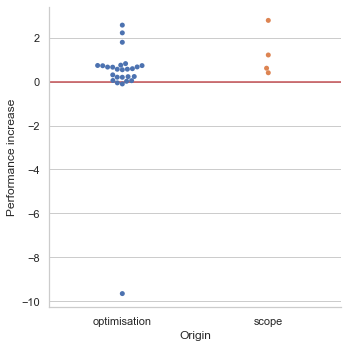

In [27]:
# Distribution of performance increase, global model vs local model, by scope/optimization

chart = sns.catplot(x="Origin", y="Performance increase", data=display_df, kind="swarm")
plt.axhline(0, c='r')
plt.show()

# Analysis by scope/optimization

In [28]:
from analysis import analysis_stratification_influence_raw
stratification_results, additional_stratification_results, local_results, global_results, local_baseline_results, values = analysis_stratification_influence_raw(X, y, DOIs, origins, metric=metric, predictor=pipe,
                                      test_size=0.2, n_iterations=1)

In [29]:
display_df =  pd.DataFrame(zip(stratification_results, additional_stratification_results, local_results, global_results, local_baseline_results, values), columns =['DOI', 'Origin', 'Local model', 'Global model', 'Local baseline', 'Yields'])
display_df

,DOI,Origin,Local model,Global model,Local baseline,Yields
0,Thèse,optimisation,2.533333,4.372000,29.473684,0.0
1,Thèse,optimisation,13.550000,38.403333,29.473684,0.0
2,Thèse,optimisation,2.533333,4.372000,29.473684,28.0
3,Thèse,optimisation,2.533333,4.372000,29.473684,1.0
4,Thèse,optimisation,2.533333,4.372000,29.473684,1.0
...,...,...,...,...,...,...
329,https://doi.org/10.1246/cl.2011.913,scope,63.018429,65.416667,25.318182,71.0
330,https://doi.org/10.1246/cl.2011.913,optimisation,13.171429,13.249286,25.318182,24.0
331,https://doi.org/10.1246/cl.2011.913,optimisation,13.141429,11.234286,25.318182,4.0
332,https://doi.org/10.1246/cl.2011.913,optimisation,0.470000,1.466786,25.318182,11.0


In [30]:
from sklearn.metrics import mean_squared_error
metric = r2_score

Optimisation results: -4.33789066561939
Scope results: -2.604982739339718


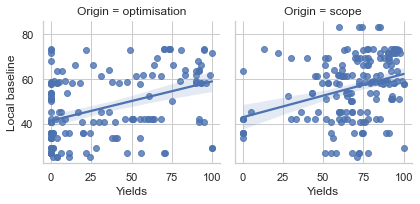

In [31]:
# Results for baseline model
g = sns.FacetGrid(display_df, col="Origin")
g.map(sns.regplot, "Yields", "Local baseline")
indexes = np.where(np.array(additional_stratification_results)=='optimisation')
print("Optimisation results: {}".format(metric(np.array(local_baseline_results)[indexes], np.array(values)[indexes])))
indexes = np.where(np.array(additional_stratification_results)=='scope')
print("Scope results: {}".format(metric(np.array(local_baseline_results)[indexes], np.array(values)[indexes])))

Optimisation results: 0.2209652713450999
Scope results: -0.5981406904148421


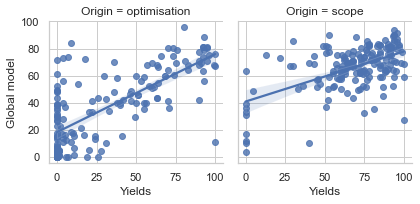

In [32]:
g = sns.FacetGrid(display_df, col="Origin")
g.map(sns.regplot, "Yields", "Global model")
indexes = np.where(np.array(additional_stratification_results)=='optimisation')
print("Optimisation results: {}".format(metric(np.array(global_results)[indexes], np.array(values)[indexes])))
indexes = np.where(np.array(additional_stratification_results)=='scope')
print("Scope results: {}".format(metric(np.array(global_results)[indexes], np.array(values)[indexes])))

Optimisation results: 0.2516687952875315
Scope results: -0.009190111302390447


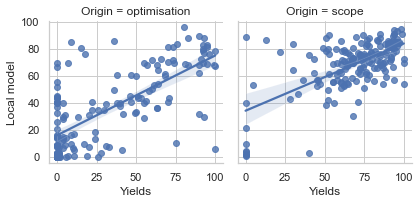

In [33]:
g = sns.FacetGrid(display_df, col="Origin")
g.map(sns.regplot, "Yields", "Local model")
indexes = np.where(np.array(additional_stratification_results)=='optimisation')
print("Optimisation results: {}".format(metric(np.array(local_results)[indexes], np.array(values)[indexes])))
indexes = np.where(np.array(additional_stratification_results)=='scope')
print("Scope results: {}".format(metric(np.array(local_results)[indexes], np.array(values)[indexes])))

# Substrate split 

In [36]:
def get_doi(df, doi='https://doi.org/10.1021/acs.organomet.9b00543'):
    df_doi = df 
    indexes = []

    for i, row in df.iterrows():
        if row["DOI"] != doi:
            indexes.append(i)
    df_doi = df_doi.drop(indexes)
    df_doi = df_doi.reset_index(drop=True)
    
    return df_doi 

In [51]:
from analysis import analysis_stratification_influence_substrates

In [52]:
strats = []
metric_model = []
metric_baseline = []
std_model = []
std_baseline = []
for doi in np.unique(df['DOI']):
    try:
        df_doi = get_doi(df, doi)
        stratification = list(df_doi["Reactant Smile (C-O)"])
        if len(np.unique(stratification))>1:
            X, y, DOIs, mechanisms, origins = process_dataframe(df_doi)
            metric_augmented, metric_baseline_augmented, unique_stratification, sizes = analysis_stratification_influence_substrates(X, y, stratification, metric=mean_absolute_error, predictor = pipe, test_size=0.1, n_iterations=2)
            metric_augmented = np.mean(metric_augmented, axis=1)
            metric_baseline_augmented = np.mean(metric_baseline_augmented, axis=1)
            metric_model.append(np.mean(metric_augmented))
            metric_baseline.append(np.mean(metric_baseline_augmented))
            std_model.append(np.std(metric_augmented))
            std_baseline.append(np.std(metric_baseline_augmented))
            strats.append(doi)
    except:
         print(doi)

In [53]:
from scipy.stats import ttest_ind, ttest_rel

stat, p = ttest_rel(metric_model, metric_baseline)
print('stat=%.3f, p=%.3f' % (stat, p))
if p > 0.05:
    print('Probably the same distribution')
else:
    print('Probably different distributions')

stat=-4.932, p=0.000
Probably different distributions


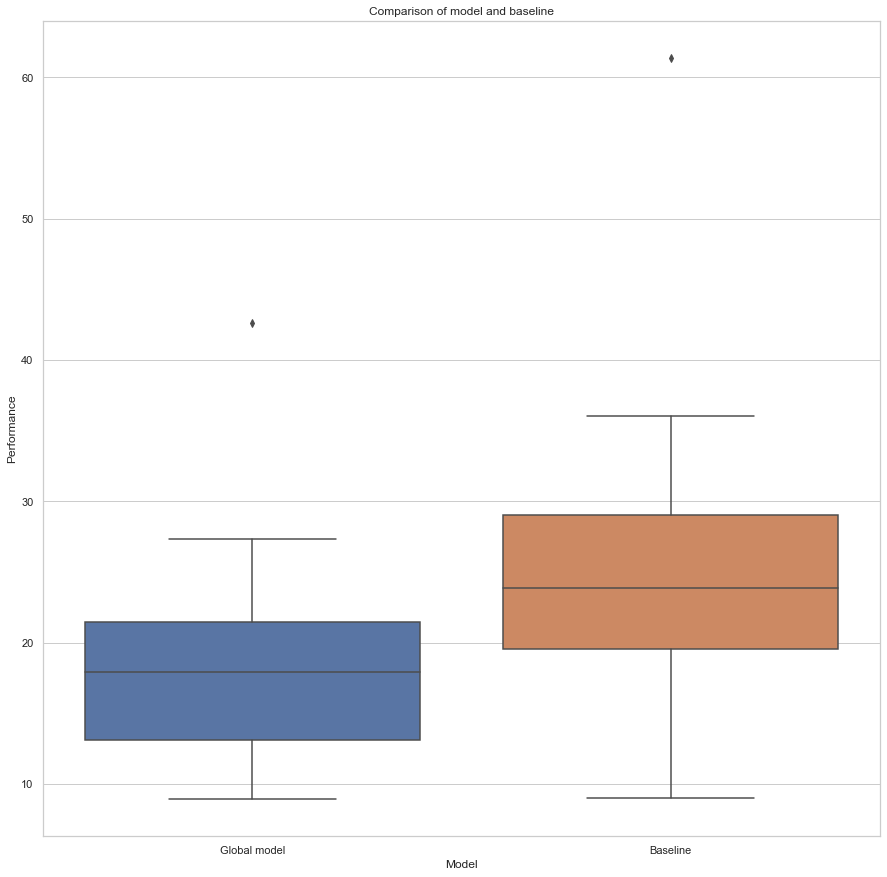

In [54]:
plt.figure(figsize=(15, 15))

global_df = pd.DataFrame(zip(metric_model, strats, ["Global model" for _ in range(len(metric_model))]), columns =['Performance', "DOI",  "Model"])
baseline_df = pd.DataFrame(zip(metric_baseline, strats, ["Baseline" for _ in range(len(metric_baseline))]), columns =['Performance', "DOI",  "Model"])

display_df = pd.concat([global_df, baseline_df])
plt.title("Comparison of model and baseline")
chart = sns.boxplot(x = "Model", y="Performance",  data=display_df)

plt.show()